# Data Pre-processing

In [ ]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
newsgroups = fetch_20newsgroups(remove=('footers', 'quotes'), subset='all')

In [ ]:
df = pd.DataFrame()
df['data'] = newsgroups['data']
df['target'] = newsgroups['target']

Same step as with BERT except for transforming to lower case.

In [ ]:
df['data'] = df['data'].apply(lambda x: x.replace("\n", "").replace("-", "").replace("....", "").lower()) 

In [ ]:
df = df.drop(df[df['data']==''].index)

## Filtering

In [ ]:
def chars_for_words(doc, threshold):
    n_words = len(doc.split())
    n_chars = len(doc)
    avg = n_chars/max(n_words,1)
    if (avg > threshold):
        return True
    else:
        False

In [ ]:
def count_charlen(df, threshold):
    count = 0
    index_list = []
    for index, row in df.iterrows():
        if (len(row['data'])>threshold):
            print(len(row['data']))
            count = count + 1
            index_list.append(index)
    return count, index_list

In [ ]:
def filter_encoded(df, threshold):
    index_list = []
    for index, row in df.iterrows():
        if chars_for_words(row['data'], threshold):
            index_list.append(index)
    return index_list

In [ ]:
i = filter_encoded(df,9)

In [ ]:
df = df.drop(i)

## Train-Test Split

In [ ]:
train, test = train_test_split(df, test_size=0.1, random_state=42)

In [ ]:
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### **Version 1 Tagging:** tag every train and test document with a unique ID.

In [ ]:
train_tagged = []
for i in range(len(train)):
  train_tagged.append(TaggedDocument(words=tokenize_text(train.iloc[i].data), tags=[i]))

### **Version 2 Tagging:** tag the train documents with the class labels while tag the test documents with unique IDs.

In [ ]:
train_tagged = train.apply(lambda x: TaggedDocument(words=tokenize_text(x['data']), tags=[x.target]), axis=1)

# Train Doc2Vec


* **dm** : {1,0}, optional
            Defines the training algorithm. If `dm=1`, 'distributed memory' (PV-DM) is used.
            Otherwise, `distributed bag of words` (PV-DBOW) is employed.
* **vector_size** : int, optional
            Dimensionality of the feature vectors.
* **negative** : int, optional
            If > 0, negative sampling will be used, the int for negative specifies how many "noise words"
            should be drawn (usually between 5-20).
            If set to 0, no negative sampling is used.
* **hs** : {1,0}, optional
            If 1, hierarchical softmax will be used for model training.
            If set to 0, and `negative` is non-zero, negative sampling will be used.
* **min_count** : int, optional
            Ignores all words with total frequency lower than this.

* **sample** : float, optional
            The threshold for configuring which higher-frequency words are randomly downsampled,
            useful range is (0, 1e-5).
* **dbow_words** : {1,0}, optional
            If set to 1 trains word-vectors (in skip-gram fashion) simultaneous with DBOW
            doc-vector training; If 0, only trains doc-vectors (faster).


In [ ]:
 import multiprocessing

cores = multiprocessing.cpu_count()

In [ ]:
model_dbow = Doc2Vec(dm=0, vector_size=200, negative=5, hs=0, min_count=2, sample = 0, dbow_words = 1, workers=cores, seed = 42)
model_dbow.build_vocab([x for x in tqdm(train_tagged)])

100%|██████████| 14800/14800 [00:00<00:00, 1538354.96it/s]


In [ ]:
%%time
model_dbow.train(train_tagged,total_examples=len(train_tagged), epochs=20)

CPU times: user 17min 35s, sys: 1.86 s, total: 17min 36s
Wall time: 8min 59s


In [ ]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs
    targets, vectors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return vectors

# **Version 1** Classification

In [ ]:
test_tagged = []
for i in range(len(train),len(test)+len(train)):
  test_tagged.append(TaggedDocument(words=tokenize_text(test.iloc[i-len(train)].data), tags=[i]))

In [ ]:
X_train = vec_for_learning(model_dbow, train_tagged)
X_test = vec_for_learning(model_dbow, test_tagged)
y_train = train['target'].values
y_test = test['target'].values

## Logistic Regression

### Grid Search

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

clf = LogisticRegression(random_state=0, solver='liblinear')
penalty = ['l1','l2']
C = [0.1,0.5,1, 10, 50,100]
#C = range(2,15)
weights = ["balanced",None]
param_grid_lr = dict(C=C, class_weight=weights, penalty=penalty)

grid = GridSearchCV(clf, param_grid_lr, cv=5, scoring='accuracy', error_score=np.nan, verbose=1)

grid.fit(X_train, y_train)

grid.score(X_test, y_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 38.2min finished


0.8790273556231003

### Train tags:0 Test tags: 0 **76%**

### Train tags present while test tags = 0.

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='liblinear', C=0.1, class_weight='balanced', penalty='l2')
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8723404255319149

### **Versin 1** Unique Train and Test Tags

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='liblinear', C=0.1, class_weight='balanced', penalty='l2')
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.780547112462006

In [ ]:
y_pred = clf.predict(X_test)
print(precision_score(y_test, y_pred, average='macro'))
print(recall_score(y_test, y_pred, average='macro'))
print(f1_score(y_test, y_pred, average='macro'))

## Support Vector Machine

### Grid Search

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

csv = SVC(random_state=0)
kernel_list = ['rbf','sigmoid','linear']
gamma_list = ['auto', 'scale']
C_list = [1/10, 1, 10, 100]
param_grid_csv = dict(C=C_list, gamma=gamma_list, kernel=kernel_list)
grid = GridSearchCV(csv, param_grid_csv, cv=5, scoring='accuracy', error_score=np.nan, verbose=1)

grid.fit(X_train, y_train)

print(grid.score(X_test, y_test))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 43.4min finished


0.880243161094225


In [ ]:
grid.best_params_

{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

### Train tags:0 Test tags: 0 **79%**

### Train tags present while test tags = 0.

In [ ]:
from sklearn.svm import SVC
clf = SVC(random_state=0, C= 1, gamma= 'scale', kernel= 'rbf')
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8182370820668693

###  **Versin 1** Unique Train and Test Tags

In [ ]:
from sklearn.svm import SVC
clf = SVC(random_state=0, C= 1, gamma= 'scale', kernel= 'rbf')
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8066869300911854

In [ ]:
y_pred = clf.predict(X_test)
print(precision_score(y_test, y_pred, average='macro'))
print(recall_score(y_test, y_pred, average='macro'))
print(f1_score(y_test, y_pred, average='macro'))

0.8027131379719517
0.7993065383080358
0.7972606178988009


# **Version 2** Similarity

In [ ]:
test_tagged = []
for i in range(len(train),len(test)+len(train)):
  test_tagged.append(TaggedDocument(words=tokenize_text(test.iloc[i-len(train)].data), tags=[i]))

In [ ]:
X_train = vec_for_learning(model_dbow, train_tagged)
X_test = vec_for_learning(model_dbow, test_tagged)
y_train = train['target'].values
y_test = test['target'].values

In [ ]:
def pred(model, X_test):
  y_pred = []
  for x in X_test:
    label = model_dbow.docvecs.most_similar([x], topn = 1)[0][0]
    y_pred.append(label)
  return y_pred

In [ ]:
 y_pred = pred(model_dbow, X_test)

In [ ]:
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))

Testing accuracy 0.8693009118541033


In [ ]:
print(precision_score(y_test, y_pred, average='macro'))
print(recall_score(y_test, y_pred, average='macro'))
print(f1_score(y_test, y_pred, average='macro'))

0.8679393001552421
0.8620532516974345
0.8621334536810025


## Metrics

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.8772036474164133
Testing F1 score: 0.8765082121269971


In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

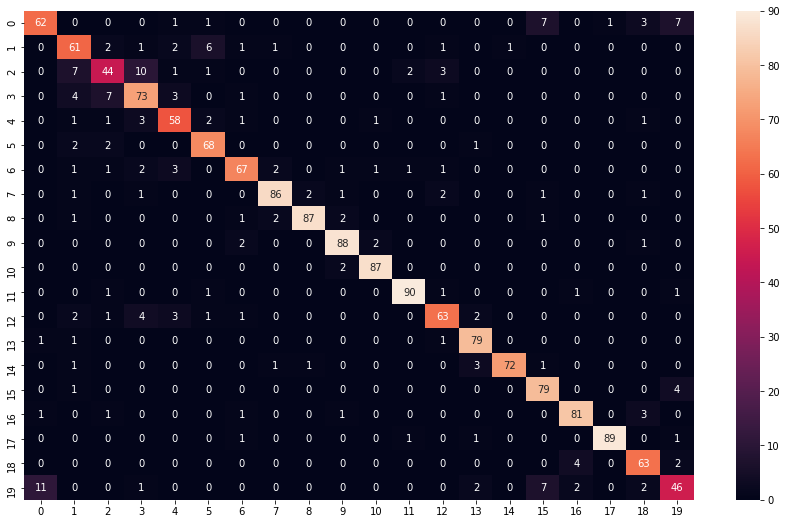

In [ ]:
fig = plt.figure(figsize=(15,9))
ax = sns.heatmap(conf_matrix, annot=True, fmt="d")

In [ ]:
pd.DataFrame(newsgroups.target_names)

,0
0,alt.atheism
1,comp.graphics
2,comp.os.ms-windows.misc
3,comp.sys.ibm.pc.hardware
4,comp.sys.mac.hardware
5,comp.windows.x
6,misc.forsale
7,rec.autos
8,rec.motorcycles
9,rec.sport.baseball
